# Segmentation Performance Evaluation
<u>Project Title</u>: Supervised Robot Tool Image Segmentation and Generation Methods \
<u>Group: 16</u> \
<u>Authors:</u> Aryaman Shodhan ashodha1,
Trisha Karani tkarani1,
Shreya Wadhwa swadhwa5,
Aidan Aug aaug1

---

**Notebook description**: This Colab Notebook evaluates the various segmentation models on the testing dataset, tracking the following metrics:
1. Inference speed per image
2. Frames per second (fps)
3. Average Dice Score
4. Total parameters in the model
5. Size in mb of the model



## Dataset Specs

**Description:**
The dataset has the following specifications:
1. A subset of Cholec80, where videos captured the procedure at 25 fps and annotated tools presence and operation phases
2. 13 different object (classes) including black background, abdominal wall, liver, gastrointestinal tract, fat, grasper, connective tissue, blood, cystic duct, L hook electrocautery (Instrument), gallbladder, hepatic vein, and liver ligament (see Data Preprocessing for visualization)
3. 3 masks --> 1 color mask, one mask used by annotation tool, and one watershed mask
4. Images are in RGB
5. Directories are such that each contains 80 consecutive frames of the video with a resolution of 854x480 and the annotated semantic segmentation masks


The link to the official dataset can be found here: https://www.kaggle.com/datasets/newslab/cholecseg8k

# Setup: 

Mounting Drive, importing libraries, and determining device

In [10]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
## Standard Library
import os
import json
import re
import random

## External Libraries
import torch
import torch.nn as nn
import torch.nn.functional as functional
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import time
from datetime import datetime
from pytz import timezone
tz = timezone('US/Eastern')

In [12]:
# GPU Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu = True if torch.cuda.is_available() else False

In [13]:
import random
random.seed(3407)
torch.manual_seed(3407)
np.random.seed(3407)

# Data Preprocessing

NOTE: MAKE SURE TO UPDATE DATA_DIR FOR THE PATH TO THE CholecSeg8k DATA!!!



The below code implements the following dataloading and pre-processing steps:
1. Loads in the data from specified repository
2. Shuffles the data
3. Splits data into an 60:10:10 train-val-test split
4. Generates an ImageDataset class based on this data for feeding into a dataloader
5. Resizes images into 192 x 320 pixel images
6. Visualizes data

In [14]:
### ENTER BASE DATA DIRECTORY HERE TO PROJECT PATH:
# data_dir = "/content/gdrive/MyDrive/Deep_Learning/" #Aryaman
# data_dir = "/content/gdrive/MyDrive/Notes/Spring 2023/Deep Learning/Deep_Learning/" #Shreya
# data_dir = "/content/gdrive/MyDrive/MLDL/Final_Project/Deep_Learning/" # Aidan
data_dir = "/content/gdrive/MyDrive/Deep_Learning/" # Aidan second account

mask_json = f"{data_dir}archive/mapping.json"

# Fetch all of the data paths
data = []
for root, _, files in os.walk(data_dir + "archive"):
  files = sorted(filter(lambda x: re.search("(endo.png$)|(watershed_mask.png$)", x) is not None, files))
  for idx in range(len(files)):
    if (idx % 2 == 0):
      data_point = [os.path.join(root, files[idx])]
    else:
      data_point += [os.path.join(root, files[idx])]
      data.append(data_point)

random.shuffle(data)

In [15]:
class ImageDataset(Dataset):
  def __init__(self, data, mask_json, transforms=None):
    self.data = data
    self.mask_json = mask_json
    self.transforms = transforms

    with open(self.mask_json, "r") as json_file:
      self.mask = json.load(json_file)
    self.mask_num = len(self.mask)
    self.mask_values = [value for value in self.mask.values()]
    self.mask_values.sort()
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img_name, mask_name = self.data[idx]
    img = io.imread(img_name)
    mask = io.imread(mask_name)
    h, w, _ = mask.shape

    new_mask = np.zeros((h, w, self.mask_num))
    for i in range(self.mask_num):
      new_mask[:, :, i] = mask[:, :, 0] == self.mask_values[i]
    if self.transforms:
      img, new_mask = self.img_transform(img, new_mask)
    return img, new_mask

  def img_transform(self, img, mask):
    img = self.transforms(img)
    mask = self.transforms(mask)

    return img, mask

In [16]:
## Divide the data
train_range_end = int(0.8 * len(data))
val_range_end = int(0.9 * len(data))
test_range_end = int(1.0 * len(data))

train_datapoints = data[0:train_range_end]
val_datapoints = data[train_range_end:val_range_end]
test_datapoints = data[val_range_end:test_range_end]

In [17]:
# NOTE: Training with the entire dataset was too computationally expensive. 
# We have further divded the data into smaller datasets using the following split:
num_train = 600
num_val = 100
num_test = 100

In [18]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 100

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=None), #Ratios must be compatible with DeepLabv3
])

############ Generate DataLoaders ###########

train_dataset = ImageDataset(data=train_datapoints, mask_json=mask_json, transforms=img_transforms)
val_dataset = ImageDataset(data=val_datapoints, mask_json=mask_json, transforms=img_transforms)
test_dataset = ImageDataset(data=test_datapoints, mask_json=mask_json, transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(f"Batches of Training Dataloader: {len(train_dataloader)}")
print(f"Batches of Validation Dataloader: {len(validation_dataloader)}")
print(f"Batches of Testing Dataloader: {len(test_dataloader)}")


Batches of Training Dataloader: 20
Batches of Validation Dataloader: 4
Batches of Testing Dataloader: 1


### Visualize Data

In [19]:
def visualize(dataloader, n_batches=1, n_samples=1):
    for _ in range(n_batches):
        img, mask = next(iter(dataloader))
        
        img = img.numpy().transpose(0, 2, 3, 1)
        mask = mask.numpy().transpose(0, 2, 3, 1)

        for i in range(n_samples): 
            fig, ax = plt.subplots(1, 2, figsize=(9, 3))
            ax[0].imshow(img[i])
            ax[0].set_title("Input Image")    

            ax[1].imshow(np.argmax(mask[i], axis=-1), cmap="gray")
            ax[1].set_title("Ground Truth")

        plt.show()

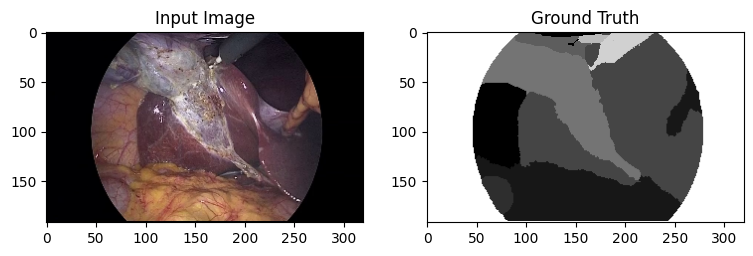

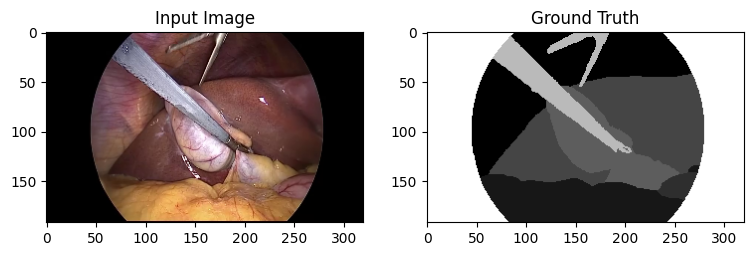

In [20]:
visualize(test_dataloader, n_batches=1, n_samples=2)

# Define Metrics Function 

In [21]:
def dice_score_image(prediction, target, n_classes):
    """ The main evaluation metric function"""
    dice_classes = np.zeros(n_classes)

    for cl in range(n_classes):
      target_cl = target[:, cl, :, :]
      prediction_cl = prediction[:, cl, :, :]

      TP = (prediction_cl * target_cl).sum().item()
      FP = ((1 - target_cl) * prediction_cl).sum().item()
      FN = (target_cl * (1 - prediction_cl)).sum().item()

      #When there is no grount truth of the class in this image
      #Give 1 dice score if False Positive pixel number is 0, 
      #give 0 dice score if False Positive pixel number is not 0 (> 0).
      if target_cl.sum() == 0 and FP == 0:
          dice_classes[cl] = 1.0
      elif target_cl.sum() == 0 and FP > 0:
          dice_classes[cl] = 0.0
      else:
        dice_classes[cl] = 2 * TP / (2 * TP + FP + FN)
    return dice_classes.mean()

In [22]:
from tabulate import tabulate
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_images(dataloader):
  """ Returns the images and masks from one dataloader iteration """
  batch_imgs, batch_masks = next(iter(dataloader))

  return batch_imgs, batch_masks

def get_metrics(model, images, masks, num_classes=13, is_deeplab_or_fcn=False):
  with torch.no_grad():
    ##### Get the average Inference Time #####
    if (not next(model.parameters()).is_cuda):
      model = model.to(device)

    images, masks = images.to(device), masks.to(device)
    
    start_time = time.time()
    for i in range(len(images)):
      pred = model(images[i].unsqueeze(dim=0))
      
    end_time = time.time()
    inference_time = (end_time - start_time) / len(images)
    fps = 1/inference_time
    
    ##### Compute Dice Score #####
    tot_dice = 0
    for i in range(len(images)):
      pred = model(images[i].unsqueeze(dim=0))
      mask = masks[i].unsqueeze(dim=0)
      if is_deeplab_or_fcn:
        pred = pred['out']

      prediction = torch.argmax(pred, dim = 1)
      prediction = nn.functional.one_hot(prediction, num_classes)
      prediction = prediction.permute(0, 3, 1, 2)

      dice_score = dice_score_image(prediction, mask, num_classes)
      tot_dice += dice_score

    tot_dice = tot_dice / len(images)

    ##### Get the model Size ######
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()


    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()


    size_all_mb = (param_size + buffer_size) / 1024**2

  return inference_time, fps, tot_dice, pytorch_total_params, size_all_mb

def print_all_metrics(data, headers):
  print(tabulate(data, headers=headers, tablefmt="fancy_grid"))


In [23]:
images, masks = get_images(test_dataloader)
print(f"Shape of Images: {images.shape}")
print(f"Shape of Masks: {masks.shape}")

Shape of Images: torch.Size([100, 3, 192, 320])
Shape of Masks: torch.Size([100, 13, 192, 320])


# Loading In All Models

## Define Model(s)

### UNET

In [24]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

        # Last layer of UNet is 1x1 convolution with 1 filter of size 1x1
        self.final_layer = nn.Conv2d(32, n_classes, kernel_size=1)

        # Will use softmax since n_classes is provided as a parameters, 
        # but this is a two class classification problem (i.e., only need sigmoid)
        self.final_activation = nn.Sigmoid()


    def forward(self, x):
        """
        Forward pass
        """
        # Encoding
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        # Decoding
        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        softmax_probs = self.final_layer(conv1m_out)
        output = self.final_activation(softmax_probs)
        
        return output


### WaveletUNet

In [25]:
!git clone https://github.com/fbcotter/pytorch_wavelets
%cd pytorch_wavelets
!pip install .

Cloning into 'pytorch_wavelets'...
remote: Enumerating objects: 978, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 978 (delta 79), reused 91 (delta 46), pack-reused 836
Receiving objects: 100% (978/978), 6.80 MiB | 41.69 MiB/s, done.
Resolving deltas: 100% (663/663), done.
/content/pytorch_wavelets
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/pytorch_wavelets
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.3.0-py3-none-any.whl size=54854 sha256=a562b96565e40a18438a558e22499540fe462dae05d2d20508d9e08d1169946a
  Stored in directory: /tmp/pip-ephem-wheel-cache-2fi4wk_c/wheels/f6/77/89/ac0462961f441a5dd4d226216613ef64f3eb2c7f2883efcebf
Successfully built pytorch-wavelets


In [26]:
import pytorch_wavelets as pw

class WaveletTransform(nn.Module):
    def __init__(self, filter='haar'):
      super(WaveletTransform, self).__init__()
      self.dwt = pw.DWT(1, filter, 'zero')
      if (use_gpu):
        self.dwt.cuda()

    def forward(self, x):
        yl, yh = self.dwt(x)
        return yl, yh

class WaveletInverseTransform(nn.Module):
    def __init__(self, filter='haar'):
      super(WaveletInverseTransform, self).__init__()
      self.idwt = pw.IDWT(filter, 'zero')
      if (use_gpu):
        self.idwt.cuda()

    def forward(self, yl, yh):
      return self.idwt((yl, yh))


## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def conv_1x1(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 1, 1, 0, bias=False),
                    nn.ReLU())


import torch.nn as nn


# U-Net
class WaveletUNET(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(WaveletUNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # WAVELET TRANSFORM TO DOWNSAMPLE
        self.downsample = WaveletTransform()
        self.upsample = WaveletInverseTransform()
        self.conv1x1_4= conv_1x1(256, 128)
        self.conv1x1_3= conv_1x1(128, 64)
        self.conv1x1_2= conv_1x1(64, 32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations

        # Last layer of UNet is 1x1 convolution with 1 filter of size 1x1
        self.final_layer = nn.Conv2d(32, n_classes, kernel_size=1)

        # Will use softmax since n_classes is provided as a parameters, 
        # but this is a two class classification problem (i.e., only need sigmoid)
        self.final_activation = nn.Sigmoid()
        self.relu = nn.ReLU()


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        yl_1, yh_1 = self.downsample(conv1_out)
        conv2_out = self.conv2(yl_1)
        yl_2, yh_2 = self.downsample(conv2_out)
        conv3_out = self.conv3(yl_2)
        yl_3, yh_3 = self.downsample(conv3_out)
        conv4_out = self.conv4(yl_3)

        conv4_out = self.conv1x1_4(conv4_out)
        conv4m_out_ = torch.cat((self.relu(self.upsample(conv4_out, yh_3)), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out = self.conv1x1_3(conv3m_out)
        conv3m_out_ = torch.cat((self.relu(self.upsample(conv3m_out, yh_2)), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)
        
        conv2m_out = self.conv1x1_2(conv2m_out)
        conv2m_out_ = torch.cat((self.relu(self.upsample(conv2m_out, yh_1)), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        softmax_probs = self.final_layer(conv1m_out)
        output = self.final_activation(softmax_probs)
        
        return output


## Load in saved model

In [27]:
models_path = data_dir + "saved_models/models/"

saved_unet = torch.load(models_path + "unet_trained_2023_05_07_14.pt")
saved_unet_aug = torch.load(models_path + "unet_data_aug_2023_05_07_20.pt")

saved_wavelet_unet = torch.load(models_path + "wavelet_unet_2023_05_07_14.pt")
saved_wavelet_unet_data_aug = torch.load(models_path + "wavelet_unet_data_aug_2023_05_07_20.pt")

saved_deeplabv3 = torch. load(models_path + "deeplabV3_trained_2023_05_07_15.pt")
saved_deeplabv3_recolor = torch.load(models_path + "deeplabV3_recolored_segmentation_2023_05_07_17.pt")
saved_deeplabv3_aug = torch. load(models_path + "deeplabV3_trained_aug_2023_05_07_17.pt")
saved_deeplabv3_noise = torch.load(models_path + "deeplabV3_trained_noise_2023_05_07_19.pt")

saved_fcn = torch.load(data_dir + "saved_models/models/fcn_trained_2023_05_08_18.pt")
saved_fcn_recolor = torch.load(data_dir + "saved_models/models/fcn_recolored_segmentation_2023_05_08_14.pt")
saved_fcn_aug = torch.load(data_dir + "saved_models/models/fcn_trained_aug_2023_05_08_16.pt")
saved_fcn_noise = torch.load(data_dir + "saved_models/models/fcn_trained_noise_2023_05_08_17.pt")

# Evaluate Model Performances

### Get metrics for models

In [28]:
from torchvision import models
import torchvision

data = []

unet_metrics = list(get_metrics(saved_unet, images, masks))
unet_metrics.insert(0, "UNet")
unet_metrics_data_aug = list(get_metrics(saved_unet_aug, images, masks))
unet_metrics_data_aug.insert(0, "UNet\nData Aug")

### Redefine UNet

In [29]:
## Redefine UNET as in recolorization module
class UNET(nn.Module):

  def __init__(self, n_classes, useBN=True):
    super(UNET, self).__init__()
    # Downgrade Stages
    self.conv1 = add_conv_stage(dim_in=3, dim_out=32, useBN=useBN)
    self.conv2 = add_conv_stage(dim_in=32, dim_out=64, useBN=useBN)
    self.conv3 = add_conv_stage(dim_in=64, dim_out=128, useBN=useBN)
    self.conv4 = add_conv_stage(dim_in=128, dim_out=256, useBN=useBN)

    # Upgrade Stages
    self.conv3m = add_conv_stage(dim_in=256, dim_out=128, useBN=useBN)
    self.conv2m = add_conv_stage(dim_in=128, dim_out=64, useBN=useBN)
    self.conv1m = add_conv_stage(dim_in=64, dim_out=32, useBN=useBN)

    # Maxpool
    self.max_pool = nn.MaxPool2d(kernel_size=2)

    # Upsample Layers
    self.upsample43 = upsample(ch_coarse=256, ch_fine=128)
    self.upsample32 = upsample(ch_coarse=128, ch_fine=64)
    self.upsample21 = upsample(ch_coarse=64, ch_fine=32)

    # Final Layer
    self.conv1x1 = add_conv_stage(dim_in=32, dim_out=n_classes, kernel_size=1, padding=0, useBN=useBN)

  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), dim=1)
    conv3m_out = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), dim=1)
    conv2m_out = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), dim=1)
    conv1m_out = self.conv1m(conv2m_out_)

    conv_out = self.conv1x1(conv1m_out)

    return conv_out

### Continue getting metrics for models

In [30]:
saved_unet_recolor = torch.load(models_path + "unet_recolored_no_freeze_2023_05_08_18.pt")
unet_metrics_recolor = list(get_metrics(saved_unet_recolor, images, masks))
unet_metrics_recolor.insert(0, "UNet\nRecolor")
data.append(unet_metrics)
data.append(unet_metrics_recolor)
data.append(unet_metrics_data_aug)

wunet_metrics = list(get_metrics(saved_wavelet_unet, images, masks))
wunet_metrics.insert(0, "WaveletUNet")
wunet_metrics_aug = list(get_metrics(saved_wavelet_unet_data_aug, images, masks))
wunet_metrics_aug.insert(0, "WaveletUNet\Data Aug")
data.append(wunet_metrics)
data.append(wunet_metrics_aug)

deeplabv3_metrics = list(get_metrics(saved_deeplabv3, images, masks, is_deeplab_or_fcn = True))
deeplabv3_metrics.insert(0, "DeepLabV3")
deeplabv3_recolorization_metrics = list(get_metrics(saved_deeplabv3_recolor, images, masks, is_deeplab_or_fcn = True))
deeplabv3_recolorization_metrics.insert(0, "DeepLabV3\nRecolorization")
deeplabv3_metrics_data_aug = list(get_metrics(saved_deeplabv3_aug, images, masks, is_deeplab_or_fcn = True))
deeplabv3_metrics_data_aug.insert(0, "DeepLabV3\nData Aug")
deeplabv3_metrics_trained_noise = list(get_metrics(saved_deeplabv3_noise, images, masks, is_deeplab_or_fcn = True))
deeplabv3_metrics_trained_noise.insert(0, "DeepLabV3\nAdversarial")
data.append(deeplabv3_metrics)
data.append(deeplabv3_recolorization_metrics)
data.append(deeplabv3_metrics_data_aug)
data.append(deeplabv3_metrics_trained_noise)

fcn_metrics = list(get_metrics(saved_fcn, images, masks, is_deeplab_or_fcn = True))
fcn_metrics.insert(0, "FCN")
fcn_metrics_recolor = list(get_metrics(saved_fcn_recolor, images, masks, is_deeplab_or_fcn = True))
fcn_metrics_recolor.insert(0, "FCN\nRecolorization")
fcn_metrics_data_aug = list(get_metrics(saved_fcn_aug, images, masks, is_deeplab_or_fcn = True))
fcn_metrics_data_aug.insert(0, "FCN\nData Aug")
fcn_metrics_noise = list(get_metrics(saved_fcn_noise, images, masks, is_deeplab_or_fcn = True))
fcn_metrics_noise.insert(0, "FCN\nAdversarial")
data.append(fcn_metrics)
data.append(fcn_metrics_recolor)
data.append(fcn_metrics_data_aug)
data.append(fcn_metrics_noise)

In [31]:
print_all_metrics(data, headers = ["Model", "Inference Time\n(s per image)", "fps", "Dice Score\n (out of 1.0)", "Number\nParameters", "Size (MB)"])

╒══════════════════════╤══════════════════╤═════════╤═════════════════╤══════════════╤═════════════╕
│ Model                │   Inference Time │     fps │      Dice Score │       Number │   Size (MB) │
│                      │    (s per image) │         │    (out of 1.0) │   Parameters │             │
╞══════════════════════╪══════════════════╪═════════╪═════════════════╪══════════════╪═════════════╡
│ UNet                 │        0.0856849 │ 11.6707 │        0.932141 │      2444685 │     9.33658 │
├──────────────────────┼──────────────────┼─────────┼─────────────────┼──────────────┼─────────────┤
│ UNet                 │        0.0118241 │ 84.5727 │        0.797778 │      2444685 │     9.33658 │
│ Recolor              │                  │         │                 │              │             │
├──────────────────────┼──────────────────┼─────────┼─────────────────┼──────────────┼─────────────┤
│ UNet                 │        0.0118129 │ 84.6529 │        0.845556 │      2444685 │     